We start by loading in the Twitter dataset as described in the synopsis. 

In [1]:
import gc
import string
import re
import numpy as np
import pandas as pd
import nltk
nltk.download('words')
import gensim.downloader as api
import matplotlib.pyplot as plt

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\simwe\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


Load in the raw data

In [2]:
raw = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', on_bad_lines='skip', names='target,user_id,date,flag,user,text'.split(','))

Initial data exploration

In [3]:
raw.head()

,target,user_id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
raw['target'].value_counts()

0    800000
4    800000
Name: target, dtype: int64

Sample 20,000 rows from the original dataset

In [5]:
# stratified sampling
tweets = raw.groupby('target').apply(lambda x: x.sample(10000, random_state=42))

In [6]:
tweets = tweets.reset_index(drop=True)

In [7]:
tweets['target'].value_counts()

0    10000
4    10000
Name: target, dtype: int64

In [8]:
tweets.head()

,target,user_id,date,flag,user,text
0,0,1974671194,Sat May 30 13:36:31 PDT 2009,NO_QUERY,simba98,@xnausikaax oh no! where did u order from? tha...
1,0,1997882236,Mon Jun 01 17:37:11 PDT 2009,NO_QUERY,Seve76,A great hard training weekend is over. a coup...
2,0,2177756662,Mon Jun 15 06:39:05 PDT 2009,NO_QUERY,x__claireyy__x,"Right, off to work Only 5 hours to go until I..."
3,0,2216838047,Wed Jun 17 20:02:12 PDT 2009,NO_QUERY,Balasi,I am craving for japanese food
4,0,1880666283,Fri May 22 02:03:31 PDT 2009,NO_QUERY,djrickdawson,Jean Michel Jarre concert tomorrow gotta work...


Now, we write a function that cleans the data. I will detail what each line of code does to make it clear.

In [9]:
# apply this to each tweet
def clean_data(tweet):
    # removal of punctuations
    tweet = re.sub("[^-9A-Za-z ]", "" , tweet)
    # convert to lowercase
    tweet = "".join([i.lower() for i in tweet if i not in string.punctuation])
    # tokenize the words temporarily
    word_tokens = nltk.tokenize.word_tokenize(tweet)
    # removal of non-alphabetical words
    word_tokens = [w for w in word_tokens if w.isalpha()]
    # removal of non-english words like usernames
    words = set(nltk.corpus.words.words())
    word_tokens = [w for w in word_tokens if w in words]
    # removal of stop-words
    stop_words = nltk.corpus.stopwords.words('english')
    word_tokens = [w for w in word_tokens if not w in stop_words]
    # stemming
    # stemmer = nltk.stem.PorterStemmer()
    # word_tokens = [stemmer.stem(w) for w in word_tokens]
    # join back as string
    tweet = " ".join(word_tokens)
    return tweet

In [10]:
# compare the tweet before and after processing
print('Original:', tweets['text'][0])
print('Processed:', clean_data(tweets['text'][0]))

Original: @xnausikaax oh no! where did u order from? that's horrible 
Processed: oh u order thats horrible


In [11]:
tweets['cleaned_text'] = tweets['text'].apply(clean_data)
tweets = tweets.drop(columns=['text'])
tweets.head()

,target,user_id,date,flag,user,cleaned_text
0,0,1974671194,Sat May 30 13:36:31 PDT 2009,NO_QUERY,simba98,oh u order thats horrible
1,0,1997882236,Mon Jun 01 17:37:11 PDT 2009,NO_QUERY,Seve76,great hard training weekend couple days rest l...
2,0,2177756662,Mon Jun 15 06:39:05 PDT 2009,NO_QUERY,x__claireyy__x,right work go free
3,0,2216838047,Wed Jun 17 20:02:12 PDT 2009,NO_QUERY,Balasi,craving food
4,0,1880666283,Fri May 22 02:03:31 PDT 2009,NO_QUERY,djrickdawson,jean concert tomorrow got ta work though


In [12]:
gc.collect()

83

Save as a csv file

In [13]:
tweets.to_csv('tweets.csv')

Now, we have the sampled dataset with pre-processed tweet text.

In [14]:
tweets = pd.read_csv('tweets.csv', index_col=0)

In [15]:
tweets = tweets.drop(columns=['user_id', 'date', 'flag', 'user'])

In [16]:
tweets.head()

,target,cleaned_text
0,0,oh u order thats horrible
1,0,great hard training weekend couple days rest l...
2,0,right work go free
3,0,craving food
4,0,jean concert tomorrow got ta work though


Remove any rows that have missing null values for cleaned text. 
This ensures that the pre-trained model has no issues processing the text.

In [17]:
tweets = tweets.dropna(axis=0)

In [18]:
tweets['target'] = tweets['target'].apply(lambda x: 1 if x==4 else 0)

Now, we obtain the phrasal embeddings for each cleaned tweet text in the tweets dataframe.
We use the GloVe Twitter 25 model, which contains pre-trained GloVe vectors based on 2 billion tweets, 27 billion tokens, and 1.2 million vocabulary.

Load in the pre-trained model

In [19]:
model = api.load('glove-twitter-25')

In [20]:
# takes in a tweet and outputs a list of word embeddings for each word
def get_embeddings(text):
    return np.array([model[w] for w in text.split() if model.__contains__(w)])

tweets['tokenized_text'] = tweets['cleaned_text'].apply(get_embeddings)
tweets.head()

,target,cleaned_text,tokenized_text
0,0,oh u order thats horrible,"[[0.34172, -0.17305, 0.23311, 0.057375, -0.761..."
1,0,great hard training weekend couple days rest l...,"[[-0.84229, 0.36512, -0.38841, -0.46118, 0.243..."
2,0,right work go free,"[[-0.43876, 0.095692, 0.0030075, -0.13195, -0...."
3,0,craving food,"[[-1.2275, 0.61425, 0.23204, 0.4787, -0.55766,..."
4,0,jean concert tomorrow got ta work though,"[[-0.70756, -1.2247, 0.087766, 0.27264, -0.412..."


Save as a csv file

In [22]:
tweets.to_csv('tweets.csv')

## Defining the Cluster Points and Centroids

In this section, we will define the cluster points and centroids in an OOP format. The requirements of each object class are as follows:

Class VectorSpace:

        Attributes:
        - Points: List(Points)
        - Centroids: List(Centroids)
        - Points Look Up table: Dict{String : Point}
        - Centroid Look Up table: Dict{String : Centroid}

        Methods:
        - Injest Points -> List(Points)
        - Inject Centroids -> List(Points)
        - Tweets to Vector Space -> True
        - Vader to Vector Space -> True
        - Calculate Cosine Similarity between 2 Points -> Float
        - Get most similar centroid to a point and the similarity score -> Centroid, Float
        - Assign Static Clusters -> Boolean
        - Assign Dynamic Clusters -> Boolean
        - Translate Document -> List(Float)
        - Plot Points and Centroids -> plt

Class Point:

        Attributes:
        - Vector Location: Array(Float)
        - Closest centroid: Point
        - Similarity with closest centroid: Float
        - Polarity: Int

        Methods:
        - Calculate Cosine Similarity with own centroid -> Float
        - Set centroid -> Boolean
        - Set polarity -> Boolean
        - Set similarity -> Boolean

Class Centroid(Point):

        Attributes:
        - Super.Point Attributes
        - Points assigned: List(Points)
        
        Methods:
        - Reset cluster: Boolean
        - Add Point to cluster: Boolean
        - Update vector location: Array(Float)

In [24]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

In [25]:
model = api.load('glove-twitter-25')
tweets = pd.read_csv('tweets.csv', index_col=0)
tweets

,target,cleaned_text,tokenized_text
0,0,oh u order thats horrible,[[ 3.4172e-01 -1.7305e-01 2.3311e-01 5.7375e...
1,0,great hard training weekend couple days rest l...,[[-8.4229e-01 3.6512e-01 -3.8841e-01 -4.6118e...
2,0,right work go free,[[-4.3876e-01 9.5692e-02 3.0075e-03 -1.3195e...
3,0,craving food,[[-1.2275 0.61425 0.23204 0.4787 -0.5...
4,0,jean concert tomorrow got ta work though,[[-7.0756e-01 -1.2247e+00 8.7766e-02 2.7264e...
...,...,...,...
19995,1,arms morning baby face boy guitar hero,[[-1.4197 -0.59392 0.034198 0.7004 0.1...
19996,1,sweet mother extend royal welcome,[[-1.0864 -0.61674 0.33613 0.43232 -0.2...
19997,1,wouldnt mind watching derby mint julep,[[ 5.7749e-02 1.3264e+00 -1.6871e-02 -5.5858e...
19998,1,shiny nice like shiny hate vista mean passion,[[-9.4931e-01 -5.5718e-01 1.3540e-01 -1.2416e...


In [26]:
class Point:
    '''
    A class used to represent each word in a document
    ...

    Attributes
    ----------
    word : str
        The word represented by the point

    vector : array
        The vector representation of the word
    
    closest_centroid : Centroid
        The closest centroid to the point

    cosine_similarity_with_centroid : Centroid
        The cosine similarity with the point's closest centroid

    polarity : Float
        The polarity of the point as determined by the polarity of its closest centroid


    Methods
    ----------
    set_centroid(centroid)
        Stores the centroid the point is assigned to

    set_consine_similarity_with_centroid(similarity)
        Sets the cosine similarity between the point and its closest centroid

    set_polarity(polarity)
        Sets the polarity of the point as determined by the polarity of its closest centroid

    '''
    def __init__(self, word, model):
        self.word = word
        self.vector = model[word] if model.__contains__(word) else None
        self.closest_centroid = None
        self.cosine_similarity_with_centroid = None
        self.polarity = None

    def set_centroid(self, centroid):
        self.centroid = centroid
        return True

    def set_consine_similarity_with_centroid(self, similarity):
        self.cosine_similarity_with_centroid = similarity
        return True

    def set_polarity(self, polarity):
        self.polarity = polarity
        return True

    def get_cosine_similarity_with_centroid(self, mean_distance=False):
        if self.closest_centroid is not None:
            if not mean_distance:
                return self.cosine_similarity_with_centroid
            else:
                return np.mean([point.cosine_similarity_with_centroid for point in self.closest_centroid.points])
        else:
            raise Exception('Unable to calculate cosine similarity with NoneType: Centroid is undefined')

In [27]:
class Centroid(Point):
    '''
    A class used to represent each word in the lexical dictionary as a centroid. 
    ...

    Attributes
    ----------
    word : str
        The word represented by the point

    vector : array
        The vector representation of the word
    
    closest_centroid : Centroid
        The closest centroid to the point

    cosine_similarity_with_centroid : Centroid
        The cosine similarity with the point's closest centroid

    polarity : Float
        The polarity of the point as determined by the polarity of its closest centroid

    cluster_points : List(Points)
        A list containing the Points assigned to the centroid as a cluster


    Methods
    ----------
    resest_cluster()
        resets the cluster to an empty list

    add_point_to_cluster(point, similarity)
        adds a Point to the centroid's cluster. Updates the Point's polarity, centroid and cosine similarity with that of and with the Centroid

    update_vector_location()
        For use in the dynamic clustering algorithm. Updates the vector location to the mean of all its points.

    '''
    def __init__(self, word, polarity, model):
        super.__init__(word, model)
        self.polarity = polarity
        self.cluster_points = []

    def reset_cluster(self):
        self.cluster_points = []
        return True

    def add_point_to_cluster(self, point, similarity):
        self.cluster_points.append(point)
        point.set_polarity(self.polarity)
        point.set_centroid(self)
        point.set_set_consine_similarity_with_centroid(similarity)
        return True

    def update_vector_location(self):
        cluster_mean = sum([point.vector for point in self.cluster_points])/len(self.cluster_points)
        self.vector = cluster_mean
        return True

In [28]:
class VectorSpace:
    '''
    A class used to represent the Vector Space which will contain the points and centroids. 
    Separate VectorSpaces should be used for the Static and Dynamic Clustering approaches respectively.
    ...

    Attributes
    ----------
    points : List(Points)
        The list of Points within the vector space.

    centroids : List(Centroids)
        The list of Centroids within the vector space.

    points_look_up_table : Dict(Str:Point)
        A look-up table to store the reference Points of each word. Allows for efficient translation of text to Point attributes
    
    centroids_look_up_table : Dict(Str:Point)
        A look-up table to store the reference Centroid of each word. Allows for efficient translation of text to Centroid attributes


    Methods
    ----------
    inject_point(point)
        Injects a point into the vector space and updates the Points look-up table.

    inject_centroid(centroid)
        Injects a centroid into the vector space and updates the Centroids look-up table

    tweet_to_vector_space(tweet, model)
        Converts a tweet, aka document, of words into their respective points and injects the points into the vector space. 
        The model is the embedding model used to tokenise the text.
        If the model does not contain the word, the Point is not created.

    vader_to_vector_space(word, polarity, model)
        Converts a word from the sentiment lexical dictionary into a Centroid and injects it into the vector space.
        The model is the embedding model used to tokenise the text.
        If the model does not contain the word, the Centroid is not created.

    calculate_cosine_similarity(point1, point2)
        Calculates the cosine similarity between 2 Points

    get_most_similar_centroid(point)
        Locates the closest Centroid to the Point from all the Centroids within the VectorSpace based on Cosine Similarity. 
        Returns the closest centroid and the Cosine Similarity between the point and the Centroid.

    assign_static_clusters()
        Executes the static clustering algorithm based on the paper "Improvement of Sentiment Analysis based on clustring of Word2Vec".

    assign_dynamic_clusters()
        Executes the proposed dynamic clustering algorithm.

    translate_document(document, static=False, dynamic=False)
        Translates a document of words into their respective similarity scores. 
        If a Centroid has negative polarity, the similarity will be transformed by a multiplicative factor of -1
        If static, the mean similarity scores of all the points within a certain centroid will be returned for all these Points.
        If dynamic, the raw similary will be returned

    plot_points(n)
        Plots the first n unique Points and Centroids on a 2-dimensional plane.

    '''
    def __init__(self):
        self.points = []
        self.centroids = []
        self.points_look_up_table = {}
        self.centroids_look_up_table = {}

    def inject_point(self, point):
        self.points.append(point)
        self.points_look_up_table[point.word] = point
        return True
    
    def inject_centroid(self, centroid):
        self.centroids.append(centroid)
        self.centroids_look_up_table[centroid.word] = centroid
        return True

    def tweet_to_vector_space(self, tweet, model):
        for word in tweet.split():
            if model.__contains__(word):
                self.inject_point(Point(word, model))
            else:
                print(f"INFO: Model does not contain {word}")
        return True

    def vader_to_vector_space(self, word, polarity, model):
        if model.__contains__(word):
            self.inject_centroid(Centroid(word, polarity, model))
        return True

    def calculate_cosine_similarity(self, point1, point2):
        return cosine_similarity(point1.vector, point2.vector)

    def get_most_similar_centroid(self, point):
        most_similar_centroid = None
        max_similarity = 0

        for centroid in self.centroids:
            similarity = self.calculate_cosine_similarity(point, centroid)
            if similarity > most_similar_centroid:
                most_similar_centroid = centroid
                max_similarity = similarity

        return most_similar_centroid, max_similarity

    def assign_static_clusters(self):
        # Implement static cluster algorithm
        for point in self.points:
            most_similar_centroid, max_similarity = self.get_most_similar_centroid(point)
            most_similar_centroid.add_point_to_cluster(point, max_similarity)
        return True

    def assign_dynamic_clusters(self):
        # To do 
        # Implement dynamic cluster algorithm
        return True

    def translate_document(self, document, static=False, dynamic=False):
        output = []
        if static:
            for word in document:
                similarity_score = self.points_look_up_table[word].get_cosine_similarity_with_centroid(mean_distance=True)
                if self.points_look_up_table[word].polarity < 0:
                    similarity_score = -similarity_score
                output.append(similarity_score)

        elif dynamic:
            for word in document:
                similarity_score = self.points_look_up_table[word].get_cosine_similarity_with_centroid(mean_distance=False)
                if self.points_look_up_table[word].polarity < 0:
                    similarity_score = -similarity_score
                output.append(similarity_score)

        return output

    def plot_points(self, n):
        words = []
        vectors = []
        for point in self.points:
            if point.word not in words:
                words.append(point.word)
                vectors.append(point.vector)

        words = np.asarray(words)[:n]
        vectors = np.array(vectors)[:n]
        
        tsne = TSNE(n_components=2)
        X_tsne = tsne.fit_transform(vectors)
        plt.figure(figsize=(20,20))
        plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
        for label, x, y in zip(words, X_tsne[:, 0], X_tsne[:, 1]):
            plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")
        plt.show()
                

#### Injecting Tweets into Vector Space

In this section, we will initialise a VectorSpace, and populate it with words from the Tweets. At the same time, we will maintain a hashtable to keep track of the corresponding point for each word that we can translate the points back to words in the form of the respective maximum similarity value in O(1) time.

In [29]:
tweets

,target,cleaned_text,tokenized_text
0,0,oh u order thats horrible,[[ 3.4172e-01 -1.7305e-01 2.3311e-01 5.7375e...
1,0,great hard training weekend couple days rest l...,[[-8.4229e-01 3.6512e-01 -3.8841e-01 -4.6118e...
2,0,right work go free,[[-4.3876e-01 9.5692e-02 3.0075e-03 -1.3195e...
3,0,craving food,[[-1.2275 0.61425 0.23204 0.4787 -0.5...
4,0,jean concert tomorrow got ta work though,[[-7.0756e-01 -1.2247e+00 8.7766e-02 2.7264e...
...,...,...,...
19995,1,arms morning baby face boy guitar hero,[[-1.4197 -0.59392 0.034198 0.7004 0.1...
19996,1,sweet mother extend royal welcome,[[-1.0864 -0.61674 0.33613 0.43232 -0.2...
19997,1,wouldnt mind watching derby mint julep,[[ 5.7749e-02 1.3264e+00 -1.6871e-02 -5.5858e...
19998,1,shiny nice like shiny hate vista mean passion,[[-9.4931e-01 -5.5718e-01 1.3540e-01 -1.2416e...


In [30]:
vector_space = VectorSpace()
tweets['cleaned_text'].apply(lambda x: vector_space.tweet_to_vector_space(x, model=model))

INFO: Model does not contain unsubtle
INFO: Model does not contain unhealed
INFO: Model does not contain hardim
INFO: Model does not contain shealing
INFO: Model does not contain lexiphanic
INFO: Model does not contain outplease
INFO: Model does not contain potentiate
INFO: Model does not contain refilm
INFO: Model does not contain thyroidal
INFO: Model does not contain freeholder
INFO: Model does not contain ghostlike
INFO: Model does not contain splotchy
INFO: Model does not contain semanticist
INFO: Model does not contain downway
INFO: Model does not contain bridgeway
INFO: Model does not contain nonworking
INFO: Model does not contain interplanting
INFO: Model does not contain intercollege
INFO: Model does not contain tramming
INFO: Model does not contain rubbishy
INFO: Model does not contain vibgyor
INFO: Model does not contain potentiate
INFO: Model does not contain crickle
INFO: Model does not contain unsanity
INFO: Model does not contain shote
INFO: Model does not contain inwit

0        True
1        True
2        True
3        True
4        True
         ... 
19995    True
19996    True
19997    True
19998    True
19999    True
Name: cleaned_text, Length: 19479, dtype: bool

c:\Users\simwe\Downloads\GitHub\DTU Projects\02807-final-project\venv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\simwe\Downloads\GitHub\DTU Projects\02807-final-project\venv\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


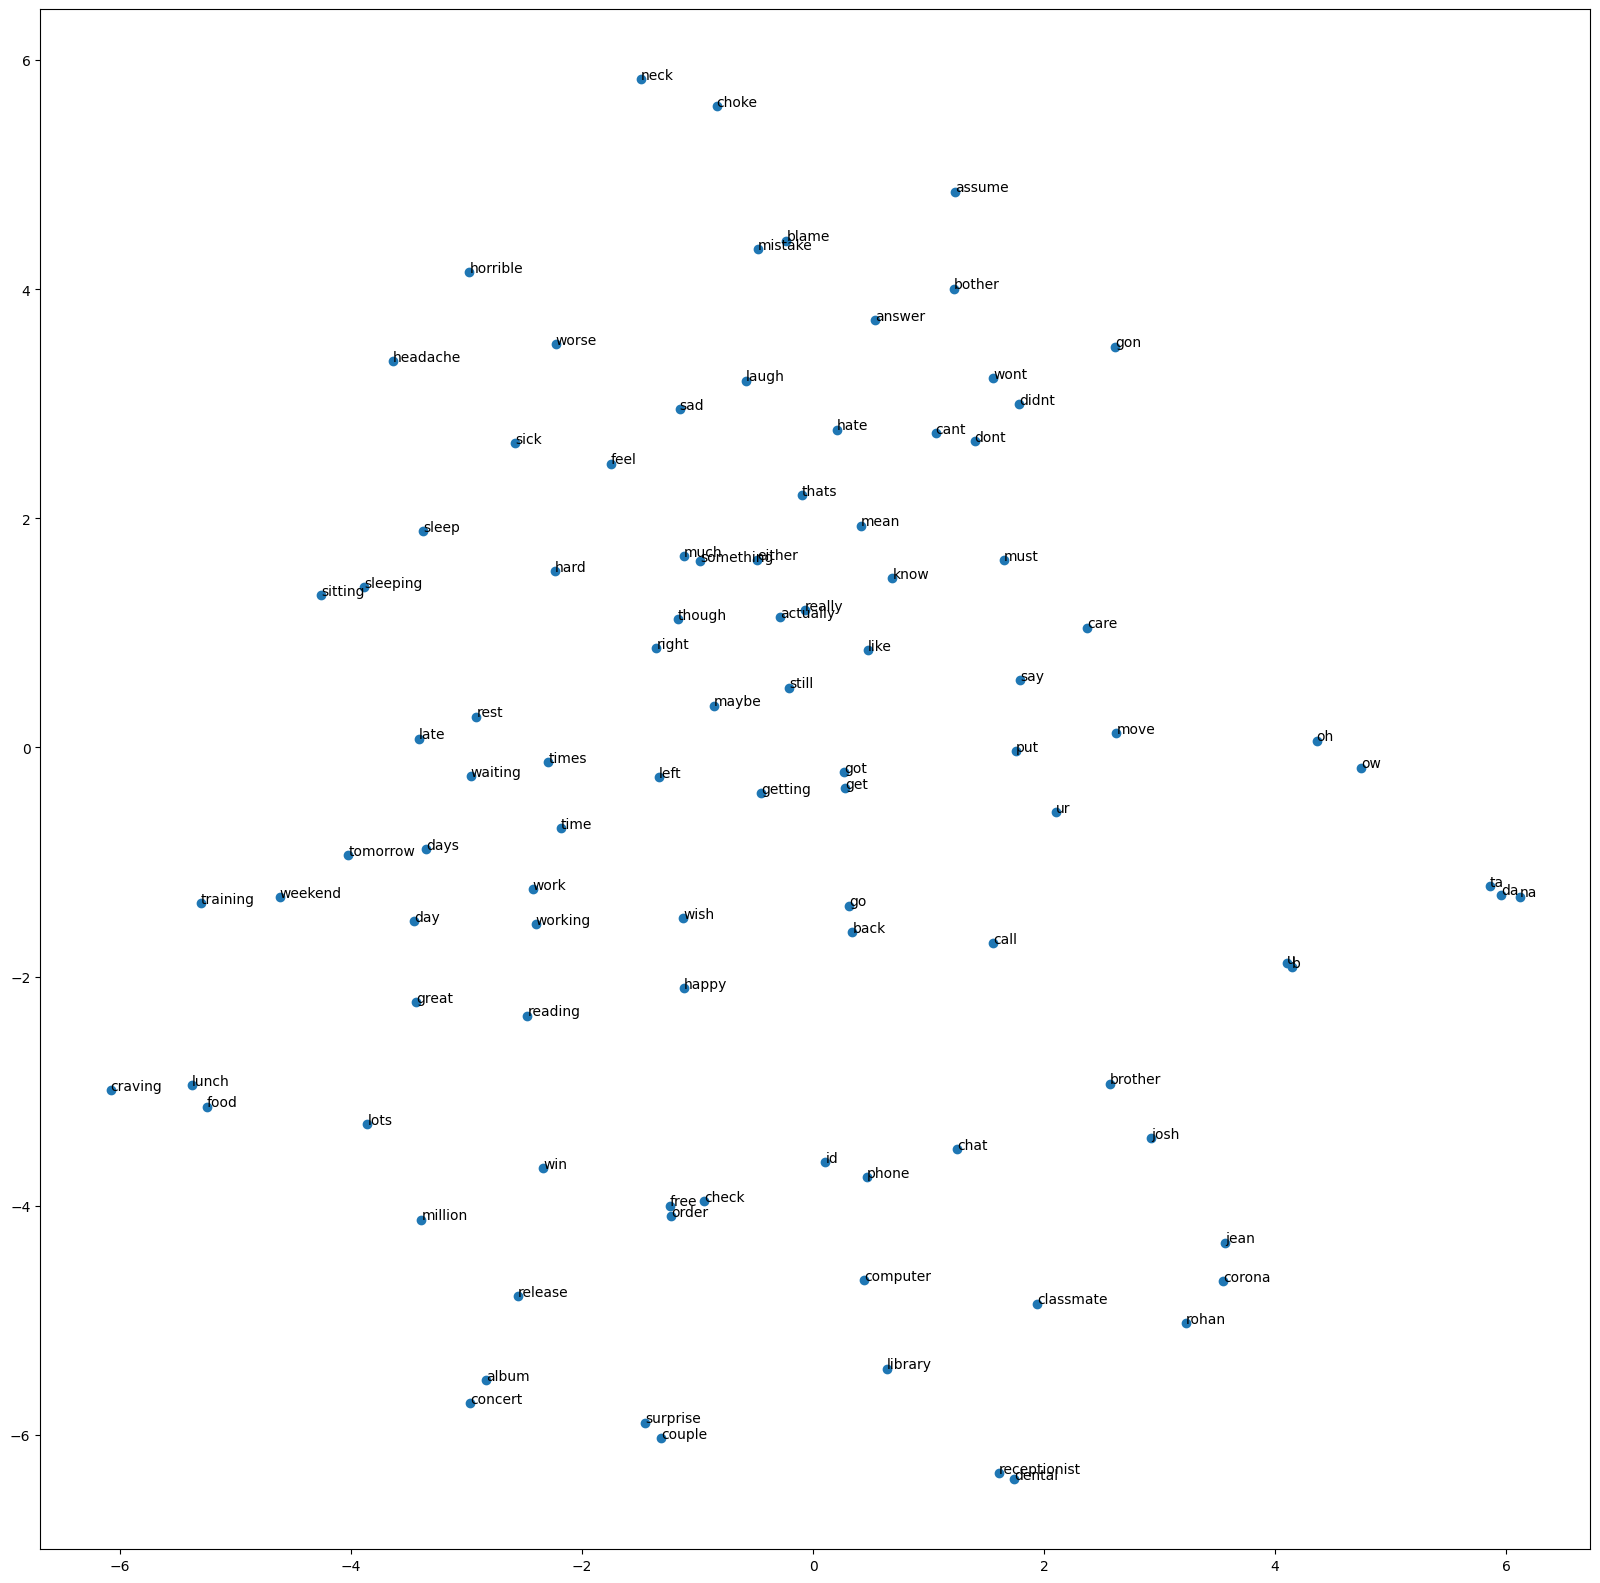

In [31]:
vector_space.plot_points(n=100)